<a href="https://colab.research.google.com/github/mleung5/cs109b/blob/main/CS109B_project_(tumor_classification_with_transfer_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Name: Automated Detection of Brain Tumor from fMRI data using Convolutional Neural Network
## Assignment: Milestone 5
## Project Number: 20
## Team Members:
1. Michelle Dai (michelledai@hsph.harvard.edu)
2. Lucy Tian (xtian@hsph.harvard.edu)
3. Hong Xiong (hongxiong@hsph.harvard.edu)
4. Michael Leung (shl004@g.harvard.edu)
5. Arturo Gamboa (arg753@g.harvard.edu)


## Index: Table of Content (TOC)

1. Introduction
2. Illustration/Flow Chart
3. Data Pipeline
4. Exploratory Data Analysis (EDA)
5. Baseline Model Architecture
6. Baseline Model Training with Elastic Deformation
7. Baseline Model Evaluation Metrics
8. Transfer Learning Data Preparation
9. First Transfer Learning Model: ResNet
10. Second Transfer Learning Model: VGG
11. Modeling Selection
12. Final Model Evaluation (VGG)
13. Future Work and Scope of Improvement
14. Conclusion & Recommendations
15. References
16. Appendix


---


## 1. Introduction

### Background and Motivation:
Brain tumors are a varied group of tumors, with glioma and non-glioma tumors being two distinct types. The survival rate of a brain tumor is largely dependent on its type and the effectiveness of its treatment. The determination of brain tumor types is typically done through a combination of imaging studies, such as MRI or CT scans, and pathological analysis of tissue samples obtained through a biopsy or surgical resection. Nevertheless, the process of identifying and classifying brain tumors demands extensive medical expertise and can be hindered by the tumor's location, which can make it challenging to retrieve a biosample for pathological examination.

<br>

Fortunately, advancements in technology have made it possible to use a CNN-based approach to learn complex patterns in fMRI data that may not be apparent to human observers. This approach has the potential to significantly improve the accuracy of brain tumor diagnosis, reduce the need for resources, and ultimately lead to better outcomes for patients.

<br>

### Problem Statement:

To address the challenges discussed above, our goal is to develop a solution that utilizes a Convolutional Neural Network (CNN) and functional magnetic resonance imaging (fMRI) data to accurately categorize a patient's brain tumor as one of the three types: Glioma, Meningioma, or Pituitary tumor. Among the three tumor types, Meningioma and Pituitary tumor are both considered non-glioma tumors.

<br>

### Data Source:

For our study, we will be utilizing data from FIGSHARE (https://figshare.com/articles/dataset/brain_tumor_dataset/1512427).

The brain T1-weighed Contrast Enhanced - fMRI dataset was acquired from Nanfang Hospital, Guangzhou, China, and General Hospital, Tianjing Medical University, China, from 2005 to 2010.

---

## 2. Illustration/Flow Chart
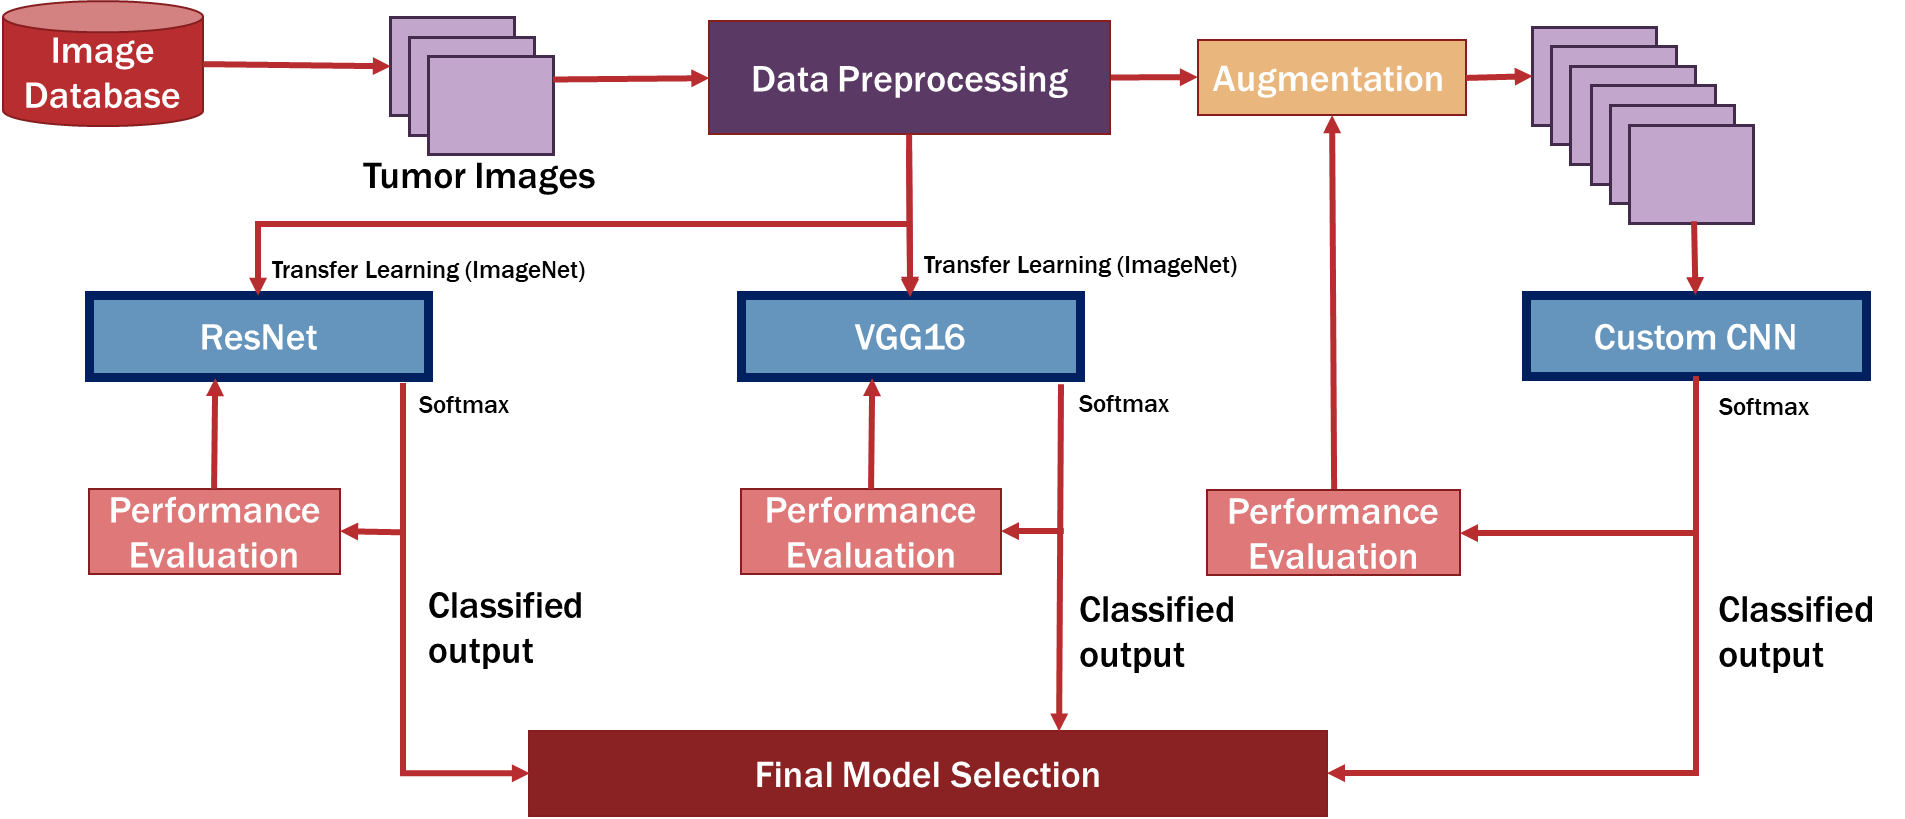
---

There is an illustration of our steps to achieve the classification of 3 tumors mentioned above:

1.   Data Preparation for Customized CNN Model (Reshape Image Size - DownSampling)
2.   Build and Train Customized CNN Model with Elastic Deformation as Baseline Model
3.   Evaluate Baseline Model Performance
4.   Data Preparation for Transfer Learning Model (Drop Outliers)
5.   Build and Train First Transfer Learning Model: ResNet
6.   Evaluate ResNet Model Performance
7.   Build and Train Second Transfer Learning Model: VGG
8.   Evaluate VGG Model Performance
9.   Final Model Selection Based on Evaluation Metrics of Three Models
10.  More Evaluations on Final Model (Saliency Map, Confusion Matrix, Classification Report)





## 3. Data Pipeline

### Import Necessary Packages

In [ ]:
#######################################
### NEEDED LIBRARIES and PACKAGES
#######################################
from sklearn.metrics import accuracy_score
import json
import pandas as pd
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
import numpy as np
from PIL import Image
!pip install elasticdeform
import elasticdeform
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
import gc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import ast
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 2.6 MB/s eta 0:00:00


### Load Data and Check Labels

In [ ]:
## Data ingestion for Model (with images and label)
data_full = pd.read_csv('/content/drive/MyDrive/CS 109B Group Project/json_reduced_data.csv')
def parse_nested_array_json(s):
    if s.startswith('[') and s.endswith(']'):
        return np.array(json.loads(s))
    else:
        return s

data_full["Image"] = data_full["Image"].apply(parse_nested_array_json)

In [ ]:
## Data Ingestion for Visualization (Including Tumor Coordinates)
data_full_vis = pd.read_csv('/content/drive/MyDrive/CS 109B Group Project/json_full_data.csv')

In [ ]:
unique_values = data_full['Label'].unique()
print("Printing unique Tumor classes:", unique_values)

Printing unique Tumor classes: [1 3 2]


In [ ]:
label_counts = data_full["Label"].value_counts()

print("Number of instances per label:")
print(label_counts)

Number of instances per label:
2    1426
3     930
1     708
Name: Label, dtype: int64


## 4. Exploary Data Analsis (EDA)


### Data Summary

Our data comprises of 3064 T1-weighted contrast-enhanced tumor slice images of 3 types: meningioma (708 slices), glioma(1,426 slices), and pituitary tumor (930 slices) from 233 patients, where each image is labeled by three experienced radiologists. The images are of 512x512 in-plane resolution, with pixel size of 0.49x0.49mm^2.

<br>

### Class Imbalance

Below is a chart for the fMRI distribution across tumor types:

| Label | Tumor Type | Counts |
|-|-|-|
| 1 | meningioma | 708 |
| 2 | glioma | 1426 |
| 3 | pituitary tumor | 930 |

As shown in the chart below, we see that glioma has approximately two times the number of samples compared to meningioma. This prompted us to include data augmentation in future model training to avoid biased results.

### Brain Tumor Preview Images for 3 Tumor Classes

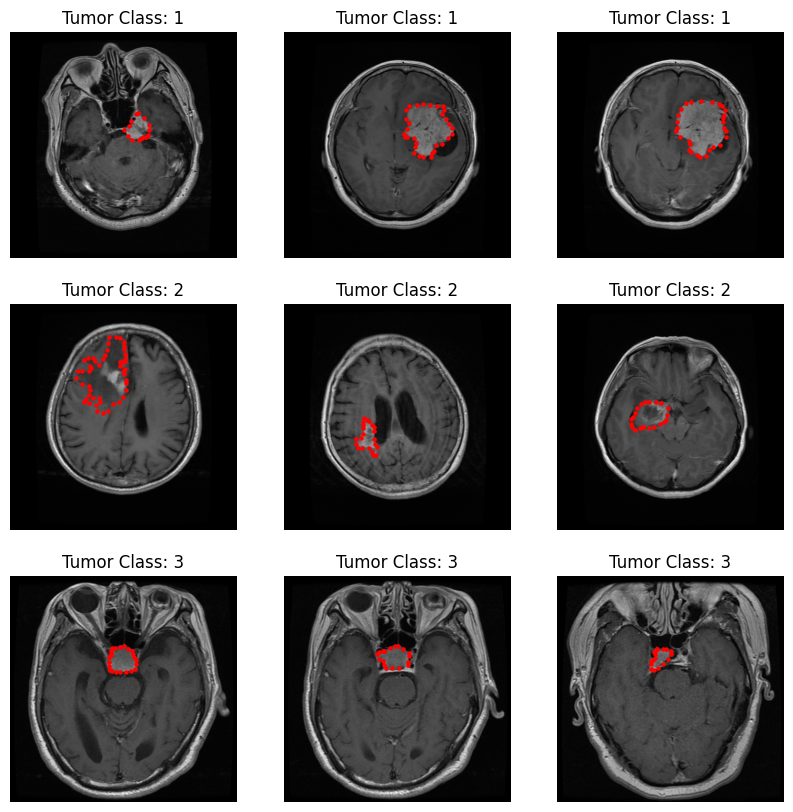

In [ ]:
##################################################################
# Previewing 9 brain images per 3 types of tumors to be predicted
##################################################################
image_list = []
border_list = []
label_list = []
for i in range(1, 4):
    label_i = data_full_vis[data_full_vis['Label']==i]
    image_list.append(label_i['Image'][3:6].tolist())
    border_list.append(label_i['TumorBorder_coordinates'][3:6].tolist())
    label_list.append([i]*3)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    images = image_list[i]
    borders_list = border_list[i]
    label = label_list[i]
    for j in range(3):
        ax[i][j].imshow(ast.literal_eval(images[j]), cmap='gray')
        borders = np.array(ast.literal_eval(borders_list[j]))
        # print(borders)
        y, x = borders[:, 0], borders[:, 1]
        # y, x = [tup[0] for tup in borders], [tup[1] for tup in borders]
        ax[i][j].scatter(x, y, s=5, color='red')
        ax[i][j].axis('off')
        ax[i][j].set_title('Tumor Class: {}'.format(label[j]))
plt.show()

As we can see from the plots, each type of tumor is displayed, with tumor borders being marked by red dots.

### Data Pre-processing & Data Preparation (Image Size Check)

In [ ]:
print("Total images to be used for model training:", data_full.shape)

Total images to be used for model training: (3064, 3)


In [ ]:
# iterating over the images to discover grayscale images that are not 512x512
print("Problematic Images that dont have expected dimensions 512x512:\n")
for i, row in data_full.iterrows():
    img = row['Image']
    if img.shape != (512, 512):
        print(f"Image Number {i}: {img.shape}")

Problematic Images that dont have expected dimensions 512x512:

Image Number 927: (256, 256)
Image Number 944: (256, 256)
Image Number 971: (256, 256)
Image Number 1060: (256, 256)
Image Number 1063: (256, 256)
Image Number 1066: (256, 256)
Image Number 1074: (256, 256)
Image Number 1082: (256, 256)
Image Number 1083: (256, 256)
Image Number 1092: (256, 256)
Image Number 1200: (256, 256)
Image Number 1202: (256, 256)
Image Number 1203: (256, 256)
Image Number 1206: (256, 256)
Image Number 1208: (256, 256)


In [ ]:
# Adding a boolean masking to discriminate the images dimensions
mask = data_full['Image'].apply(lambda x: x.shape == (512, 512))
# selecting only the rows with 512x512 images
data_full_512 = data_full[mask]

In [ ]:
print("Total images 512x512 size:", data_full_512.shape)

Total images 512x512 size: (3049, 3)


### Treating Outliers
As a team, we encountered 15 brain images that were considered outliers due to their shapes not matching the rest of the images in the dataset.

We came up with 2 solutions addressing the problem taking into consideration the architectural nature of our models explored.

1. For the **CNN baseline model**, after testing with both 512x512 and 256x256 resolutions, we found that **down-sampling the entire dataset to 256x256** provided all details needed for the convolutional model to work as effective as the high-resolution images but with less computational intensity. We decided to clean and reshape all the images to 256x256 and avoid the computational challenges

2. For our more complex **transfer learning models**, we attempted both a) throwing out the outliers, and b) up-sampling:

    a) simply remove these 15 non-compliant images during the initial model
fine-tuning and training with a reduced (~600) amount of images, allowing us to start testing multiple models. This option worked well as it enabled us to continue developing and refining different models such as VGG, ResNet, and a custom CNN model. We were able to identify strengths and weaknesses of each model by inspecting the predicting results.

    b) The second option was to upsample those 15 images to 512x512 for the whole dataset to be consistent. The reason for using upsampling rather than downsampling as in CNN baseline model is that we hope to take the advantage of potentially less computational efforts with transfer learning, since we already have a pre-trained model as a starting point, which has already learned useful features from a large dataset. Also if the input images are smaller than the trained images, upsampling the images to match the required size may lead to a loss of image quality or cause the images to appear pixelated. For this reason, we decided to keep quality for our training images. 15 images out of 3000+ sample size is very minimal. We felt very comfortable not including them into our dataset.

    Given the potential drawbacks from up-sampling, we will **remove those images with 256x256 resolutions as outliers** in our **transfer learning models**.

### Down-Sampling Data for Baseline Model

In [ ]:
# creating a new column for resized & reshaped images
data_full['ResizedImage'] = None

#iterating over the images in the dataset
for i, row in data_full.iterrows():
    img = row['Image']
    if img.shape == (512, 512):
        # resize the image to 256x256
        #img = Image.fromarray(img).resize((256, 256))
        img = Image.fromarray(img.astype('uint8')).resize((256, 256))
        # converting the image back to a numpy array and store in the new column
        data_full.at[i, 'ResizedImage'] = np.array(img)
    elif img.shape == (256, 256):
        # if image is already 256x256, store it in the new column
        data_full.at[i, 'ResizedImage'] = img
    else:
        # for any other image size, skip it
        continue

# droping anything missing pixels after reshaping the entire images dataset
data_full.dropna(inplace=True)

In [ ]:
print("Total images after reshaping & cleaning:", data_full.shape)

Total images after reshaping & cleaning: (3064, 4)


### Rationale for Normalization Method
In our normalization procedure, we divided all pixel values by 255. Grayscale images typically have pixel values ranging from 0 to 255, where 0 represents black and 255 represents white. Such normalization will facilitate faster learning and convergence by the CNN, which also helps to minimize the impact of variations in lighting and contrast in the images, leading to better model performance. Furthermore, dividing by 255 helps to prevent issues with vanishing or exploding gradients during training, which can arise if the pixel values are not properly scaled. This technique preserves the original relative intensities of the pixels, which can be crucial in image processing tasks where these intensities contain vital information about the image.

Besides dividing by 255, we had attempted min/max standardization given our original dataset has undergone pixel contrast enhancement. We found that after min/max standardization, we encountered undesirable clipping (Please refer to appendix section for explanation with codes and images).

Therefore, we proceeded with dividing by 255 as it is a widely used and simple normalization technique that is well-suited for grayscale image processing and computer vision tasks such as ours.

### Normalize Data for Baseline Model

In [ ]:
####################################
### Normalizing the images per the process explained earlier
####################################
X = np.array(data_full['ResizedImage'].tolist())
y = np.array(data_full['Label'].tolist())
X = X / 255.0

In [ ]:
print("Total images:", len(X))
print("Total Y responses:", len(y))

Total images: 3064
Total Y responses: 3064


### Split Training, Validation, and Test Data for Baseline Model

In [ ]:
################################
# Data preperation for model training
################################
# Converting y to categorical format
y_cat = to_categorical(y)

# Splitting the data into train and test sets while stratifying y
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Splitting the train set into train and validation sets while stratifying y
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print("Training dataset:", X_train.shape, y_train.shape)
print("Validation dataset:", X_val.shape, y_val.shape)
print("Test dataset:", X_test.shape, y_test.shape)

Training dataset: (1960, 256, 256) (1960, 4)
Validation dataset: (491, 256, 256) (491, 4)
Test dataset: (613, 256, 256) (613, 4)


### Reshape Data for Baseline Model Fitting

In [ ]:
# Reshaping X arrays to have 4 dimensions for model fitting
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_val = X_val.reshape(X_val.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)
print("Training dataset reshaped:", X_train.shape)
print("Validation dataset reshaped:", X_val.shape)
print("Test dataset reshaped:", X_test.shape)

Training dataset reshaped: (1960, 256, 256, 1)
Validation dataset reshaped: (491, 256, 256, 1)
Test dataset reshaped: (613, 256, 256, 1)


## 5. Baseline Model Architecture

In [ ]:
# Fitting the Model custom CNN
input_shape=X_train[0].shape
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='GlorotNormal', padding='same', input_shape=input_shape))
model_1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='GlorotNormal', padding='same'))
model_1.add(MaxPooling2D(pool_size=(3, 3)))
model_1.add(Dropout(0.2))
model_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='GlorotNormal', padding='same', input_shape=input_shape))
model_1.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='GlorotNormal', padding='same'))
model_1.add(MaxPooling2D(pool_size=(3, 3)))
model_1.add(Dropout(0.2))
# Flattenning layer
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_1.add(Dropout(0.3))
model_1.add(Dense(4, activation='softmax'))

# Compiling the model with categorical_crossentropy loss, SGD optimizer, and accuracy metric
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 128)       147584    
                                                        

### Baseline Model Capabilties:
We are featuring CNNs, regularizarion techniques such as dropout, padding, maxpooling, data augementation and kernel initializers on some layers.

It is worth mentioning that we attempted **kernel_initializer='GlorotNormal'** weight initialization technique. GlorotNormal initializer initializes the weights of the convolutional filters randomly from a normal distribution with a mean of 0 and a standard deviation calculated according to the number of input and output units. The goal of this initialization is to keep the variance of the activations roughly constant across the layers. This helps to prevent the vanishing or exploding gradients problem, which can speed up convergence and training stability. Using the GlorotNormal initializer for convolutional layers was a paramount move that really moved the needle to generalize well on the critical features.  

## 6. Baseline Model Training with Elastic Deformation

In [ ]:
def elastic_transform(image):
    alpha= 0.01
    image = image[:,:,0]
    displacement = np.random.randn(2, image.shape[0], image.shape[1]) * alpha
    deformed_image = elasticdeform.deform_grid(image, displacement)
    return deformed_image[:,:,np.newaxis]

#Calling imager displacer and deformer function
datagen = ImageDataGenerator(preprocessing_function=elastic_transform)
# Training the model using the augmented data
history_model_1 = model_1.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True,
                                                                                        monitor='val_loss')])

Epoch 1/10
62/62 [==============================] - 57s 916ms/step - loss: 0.4337 - accuracy: 0.8219 - val_loss: 0.4038 - val_accuracy: 0.8391
Epoch 2/10
62/62 [==============================] - 58s 941ms/step - loss: 0.3928 - accuracy: 0.8459 - val_loss: 0.4592 - val_accuracy: 0.8004
Epoch 3/10
62/62 [==============================] - 57s 917ms/step - loss: 0.3945 - accuracy: 0.8429 - val_loss: 0.4036 - val_accuracy: 0.8391
Epoch 4/10
62/62 [==============================] - 57s 915ms/step - loss: 0.3736 - accuracy: 0.8505 - val_loss: 0.4307 - val_accuracy: 0.8126
Epoch 5/10
62/62 [==============================] - 57s 917ms/step - loss: 0.3322 - accuracy: 0.8653 - val_loss: 0.3673 - val_accuracy: 0.8574
Epoch 6/10
62/62 [==============================] - 57s 917ms/step - loss: 0.3184 - accuracy: 0.8745 - val_loss: 0.3934 - val_accuracy: 0.8411
Epoch 7/10
62/62 [==============================] - 57s 917ms/step - loss: 0.2851 - accuracy: 0.8847 - val_loss: 0.3431 - val_accuracy: 0.8534

### Inspecting Training Results upon Elastic Deformation:
Upon inspecting the training results, we were very encouraged to see how well the Convolutional Network was learning for every epoch. One of the key factors contributing to the model's performance was the data augmentation technique we used, which was elastic deformation. This technique randomly applies small deformations to the images on the fly during training, which adds a factor of variability and can improve the model's ability to generalize to new images. The small deformations also help to create more realistic images, which can be especially important when training on a limited dataset.

The **elastic deformation** package we used provided a variety of options for controlling the degree and type of deformation applied to the images. One of the key parameters we adjusted was the alpha factor, which determines the degree of deformation applied to the images. We found that using a small alpha factor (around 0.1) was effective for adding subtle deformations without distorting the underlying structure of the images. This allowed us to preserve important features and maintain the integrity of the images while still providing enough variability to improve the model's performance (Please refer to appendix section for a sample of elasticly deformed image with alpha of 2).

Overall, we found that using elastic deformation with a small alpha factor was an effective technique for improving the performance of our CNN model. By adding variability and creating more realistic images, we were able to improve the model's ability to generalize to new images and achieve higher accuracy.  

### Baseline Model Training History

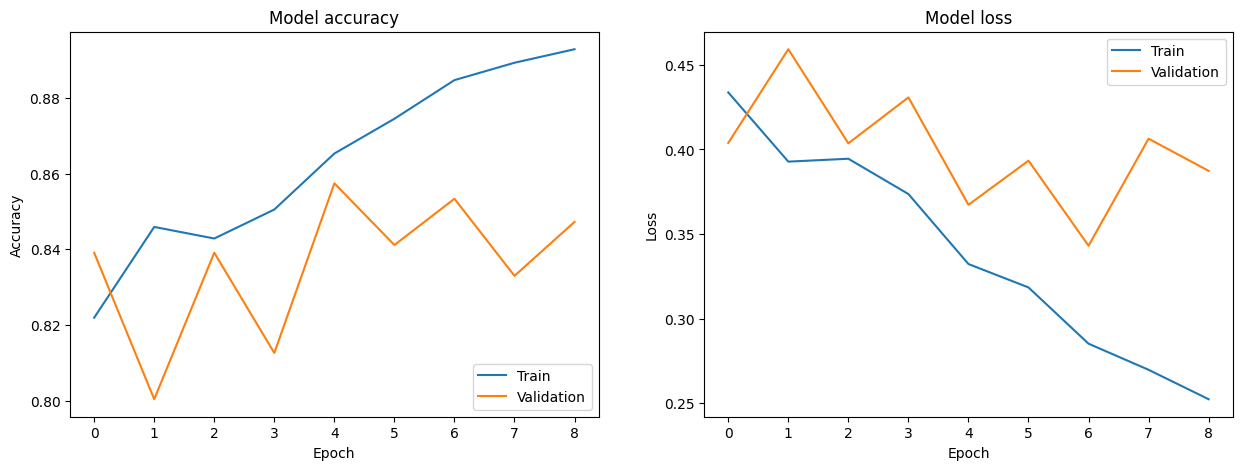

In [ ]:
# ploting results loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotting accuracy
axs[0].plot(history_model_1.history['accuracy'])
axs[0].plot(history_model_1.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot loss
axs[1].plot(history_model_1.history['loss'])
axs[1].plot(history_model_1.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')
plt.show()

Based on model **training and validation accuracy plot**, we can see there is an increase in both training and validation accuracy across epochs. However, the difference between training and validation accuracy fluctuates, suggesting that our baseline model might encounter overfitting issues.

Based on model **training and validation loss plot**, we can see the training loss has been steadily decreasing over time, suggesting a good learning performance from our model upon the training data. However, the validation loss fluctuates, and hardly converged to the training loss curve, suggesting that our baseline model might not generalize well to the unseen data.

Overall speaking, both training and validation accuracy and loss plots have shown decent learning performances, but there is room to be improved based on this fluctuation. As a result, we will consider transfer learning models in the later section.


## 7. Baseline Model Evaluation Metrics

In [ ]:
# Evaluating the model on the training data
train_loss, train_accuracy = model_1.evaluate(X_train, y_train)
print('Training loss:', train_loss)
print('Training accuracy:', train_accuracy)

# Evaluating the model on the validation set
loss, accuracy = model_1.evaluate(X_val, y_val)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

# Evaluating the model on the TEST set
loss, accuracy = model_1.evaluate(X_test, y_test)
print('Testing loss:', loss)
print('Testing accuracy:', accuracy)


62/62 [==============================] - 1s 9ms/step - loss: 0.2648 - accuracy: 0.8918
Training loss: 0.26476505398750305
Training accuracy: 0.8918367624282837
16/16 [==============================] - 0s 9ms/step - loss: 0.3431 - accuracy: 0.8534
Validation loss: 0.34306496381759644
Validation accuracy: 0.8533604741096497
20/20 [==============================] - 0s 9ms/step - loss: 0.3143 - accuracy: 0.8760
Testing loss: 0.31427517533302307
Testing accuracy: 0.8760195970535278


Both **training and validation accuracy** are relatively decent, with 89% and 85% respectively, suggesting our model is learning well from the training data. However, there is difference between training and validation loss and accuracy, suggesting that our model might slightly overfit the training data.

As we can see from the **test accuracy**, our CNN model demonstrates a solid performance on the test dataset, achieving an accuracy of 87.6%.

Our high accuracy scores across training, validation, and testing datasets are indicative of our successful implementation of CNN model. However, there is still room for improvement. Therefore, we proceed to the transfer learning section.



## 8. Transfer Learning Data Preparation

### Rationale behind Dropping 256 × 256 Images (Outliers) for Training and Testing Transfer Learning Model


| Label | Tumor Type | Counts |
|-|-|-|
| 1 | meningioma | 708 (-12 / 1.7%) |
| 2 | glioma | 1426 (-3 / 0.2%)|
| 3 | pituitary tumor | 930 |

We observe that the non-compliant shape data only comprises of 1.7% of the meningioma class and 0.2% of glioma class, which is below 5%, so it is valid to remove them (considering them as missing data, as they miss pixels as compared with 512x512 images). Also, if we edit on the entire dataset in order to accommodate these 15 samples (by upsampling or downsampling), we will encounter the risk of loss of image quality due to upsampling, which we also mentioned above in the treating outliers of EDA section.

We did not apply elastic transformation in transfer learning model considering the following: We wish to obtain the best performance by fine tuning the transfer learning model, which applying elastic transformation might significantly alter the appearance of images and hinder the fine tuning procedure.

### Remove Outliers

In [ ]:
Image = data_full["Image"]

sanity = []

for i in range(len(Image)):
    if Image[i].shape != (512, 512):
        sanity.append(i)

print(f"The Number of Images with 256 * 256 Resolutions: {len(sanity)}")
print(f"The Number of Images with 512 * 512 Resolutions: {len(Image)}")

The Number of Images with 256 * 256 Resolutions: 15
The Number of Images with 512 * 512 Resolutions: 3064


In [ ]:
data_sanity = data_full.drop(index=sanity)
data_sanity = data_sanity.reset_index()

### Split Training, Validation, and Test Data for Transfer Learning Model

In [ ]:
Image_prep = np.reshape(np.vstack(data_sanity.Image.to_list()), (-1, 512, 512, 1))

In [ ]:
# Split data into train and temporary datasets (80% train, 20% temp)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(Image_prep, data_sanity['Label'], test_size=0.2, random_state=42)

# Split the temporary dataset into validation and test sets (10% validation, 10% test)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2 , random_state=42)

# Subtract 1 from the labels to have them in the range of 0 to 2
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {X_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (1951, 512, 512, 1) - y_train shape: (1951,)
x_val shape: (488, 512, 512, 1) - y_val shape: (488,)
x_test shape: (610, 512, 512, 1) - y_test shape: (610,)


### Data Pre-processing (Reshape and Normalize Data)

In [ ]:
## convert greyscale to RGB so that it fits the VGG16 model

x_train = np.squeeze(X_train, axis=3)
x_test  = np.squeeze(X_test,  axis=3)
x_val   = np.squeeze(X_val,   axis=3)

x_train = np.repeat(x_train[..., np.newaxis], 3, -1)       ## x_train is now in RGB, duplicated from greyscale
x_test  = np.repeat(x_test[..., np.newaxis], 3, -1)        ## x_test  is now in RGB, duplicated from greyscale
x_val   = np.repeat(x_val[..., np.newaxis], 3, -1)         ## x_val   is now in RGB, duplicated from greyscale

print(f"x_train reshaped dimension: {x_train.shape}")
print(f"x_val reshaped dimension: {x_val.shape}")
print(f"x_test reshaped dimension: {x_test.shape}")

x_train reshaped dimension: (1951, 512, 512, 3)
x_val reshaped dimension: (488, 512, 512, 3)
x_test reshaped dimension: (610, 512, 512, 3)


In [ ]:
## Preprocess the data, imagenet is trained using pixel 0-255 in float [0,1]
x_train = x_train.astype('float32')/255.    ## Preprocessing the data
y_train = y_train.astype('int32')
x_val   = x_val.astype('float32')/255.    ## Preprocessing the data
y_val   = y_val.astype('int32')
x_test  = x_test.astype('float32')/255.    ## Preprocessing the data
y_test  = y_test.astype('int32')

## 9. First Transfer Learning Model: ResNet

### Load Necessary Packages for ResNet

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.preprocessing  import image
from tensorflow.keras.optimizers import Adam
from keras.applications.imagenet_utils import *
from keras.models import Model
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
import tensorflow as tf

import random

### Load ResNet Base Model

In [ ]:
img_height = 512
img_width  = 512
img_channel = 3     ## imagenet is trained on RGB

new_input = Input(shape=(img_height, img_width, img_channel))

base_model = ResNet50V2(weights='imagenet', input_tensor=new_input, include_top=False)
# base_model.summary()

### ResNet Fine-tuning with 10 Epoches

In [ ]:
# Add a global average pooling layer to reduce the spatial dimensions of the feature maps
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)

# Add a fully connected layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)

# Add a final output layer with the desired number of classes and softmax activation
num_classes = 3
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model by combining the ResNet50V2 base model with the newly added layers
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss, optimizer, and metrics
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data and validate on the validation data
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))#,callbacks=[tensorboard_callback])

Epoch 1/10
61/61 [==============================] - 21s 219ms/step - loss: 196.6673 - accuracy: 0.5167 - val_loss: 11.4796 - val_accuracy: 0.7131
Epoch 2/10
61/61 [==============================] - 7s 121ms/step - loss: 26.1697 - accuracy: 0.6448 - val_loss: 46.8299 - val_accuracy: 0.3176
Epoch 3/10
61/61 [==============================] - 7s 120ms/step - loss: 50.1432 - accuracy: 0.5710 - val_loss: 11.7282 - val_accuracy: 0.7541
Epoch 4/10
61/61 [==============================] - 7s 121ms/step - loss: 20.1012 - accuracy: 0.7032 - val_loss: 16.5524 - val_accuracy: 0.6844
Epoch 5/10
61/61 [==============================] - 7s 121ms/step - loss: 14.7095 - accuracy: 0.7196 - val_loss: 10.4071 - val_accuracy: 0.7766
Epoch 6/10
61/61 [==============================] - 7s 121ms/step - loss: 23.3865 - accuracy: 0.6648 - val_loss: 16.8329 - val_accuracy: 0.7480
Epoch 7/10
61/61 [==============================] - 7s 120ms/step - loss: 29.0974 - accuracy: 0.6561 - val_loss: 36.5596 - val_accurac

As we can see, the training accuracy from ResNet is 0.736, and validation accuracy is 0.756. Both metrics are lower than our baseline model.

### ResNet Test Accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Making predictions on the test set
y_pred = model.predict(x_test)
# Converting predictions from categorical back to integer format
y_pred_int = np.argmax(y_pred, axis=1)
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_int)
# Printing accuracy
print("Test Prediction Accuracy:", accuracy)


20/20 [==============================] - 3s 97ms/step
Test Prediction Accuracy: 0.739344262295082


The test accuracy from ResNet is 0.739, which is also lower than our baseline model.

## 10. Second Transfer Learning Model: VGG

### Load Necessary Packages for VGG

In [ ]:
! pip install tf_keras_vis
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.preprocessing  import image
from tensorflow.keras.optimizers import Adam
from keras.applications.imagenet_utils import *
from keras.models import Model
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency

import random

### Load VGG Base Model

In [ ]:
## transfer learning from keras VGG16 model weights
img_height = 512
img_width  = 512
img_channel = 3     ## imagenet is trained on RGB

new_input = Input(shape=(img_height, img_width, img_channel))
base_model = VGG16(weights='imagenet', input_tensor=new_input, include_top=False)
# base_model.summary()

### VGG Fine-Tuning with 3 Dense layers and 10 Epoches

In [ ]:
x = Flatten()(base_model.layers[-1].output)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=1024, activation='relu')(x)

# Add a final output layer with the desired number of classes and softmax activation
output = Dense(units=3, activation='softmax')(x)            ## tumor dataset

# Create the final model by combining the VGG16 base model with the newly added layers
tumor_model = Model(inputs=base_model.input, outputs=output, name='tumor_model')

## fix all weights in base_model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with appropriate loss, optimizer, and metrics
tumor_model.compile(optimizer = Adam(),
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['acc'])

# Train the model on the training data and validate on the validation data
history = tumor_model.fit(x_train,
                          y_train,
                          #validation_split=0.2,
                          validation_data=(x_val, y_val),
                          batch_size=32,
                          verbose=1,
                          epochs=10)


Epoch 1/10
61/61 [==============================] - 24s 302ms/step - loss: 226.7184 - acc: 0.7340 - val_loss: 5.4128 - val_acc: 0.9201
Epoch 2/10
61/61 [==============================] - 10s 167ms/step - loss: 5.1660 - acc: 0.9200 - val_loss: 8.3953 - val_acc: 0.9324
Epoch 3/10
61/61 [==============================] - 10s 169ms/step - loss: 6.1078 - acc: 0.9436 - val_loss: 7.2767 - val_acc: 0.9324
Epoch 4/10
61/61 [==============================] - 10s 167ms/step - loss: 1.9539 - acc: 0.9713 - val_loss: 6.3518 - val_acc: 0.9549
Epoch 5/10
61/61 [==============================] - 10s 167ms/step - loss: 1.4146 - acc: 0.9733 - val_loss: 4.2438 - val_acc: 0.9467
Epoch 6/10
61/61 [==============================] - 10s 167ms/step - loss: 0.7123 - acc: 0.9815 - val_loss: 6.3386 - val_acc: 0.9365
Epoch 7/10
61/61 [==============================] - 10s 166ms/step - loss: 1.5569 - acc: 0.9733 - val_loss: 6.4869 - val_acc: 0.9344
Epoch 8/10
61/61 [==============================] - 10s 166ms/step 

As we can see, the training accuracy from VGG is 0.982, and validation accuracy is 0.941. Both metrics are higher than our baseline model and ResNet model.

### VGG Training History Plot

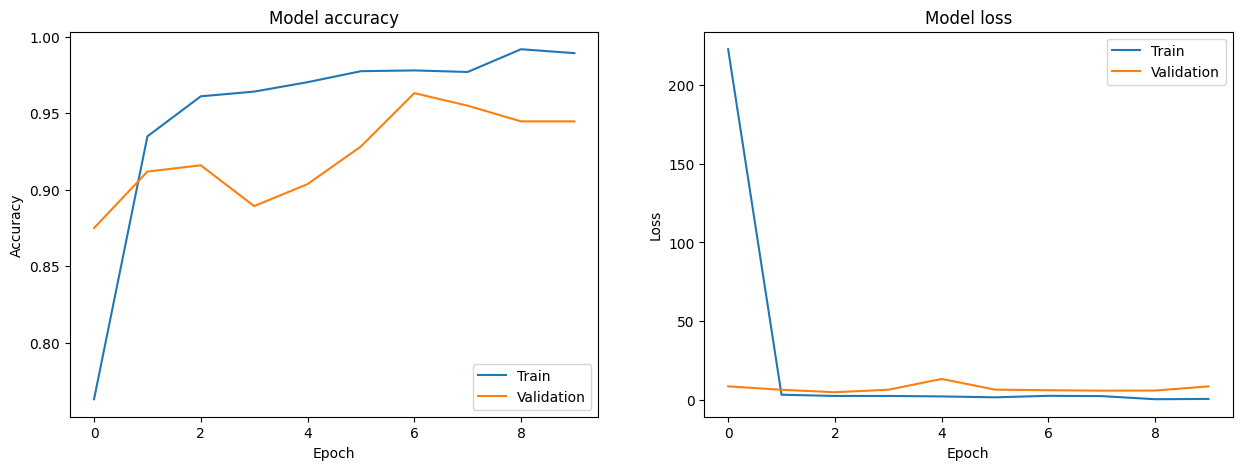

In [ ]:
# ploting results loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plotting accuracy
axs[0].plot(history.history['acc'])
axs[0].plot(history.history['val_acc'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='lower right')
# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper right')
plt.show()

Overall speaking, both model training and validation accuracy and loss plots have shown decent learning performances. The training and validation curves show solid convergence, compared to our baseline model. This suggests our transfer learning technique with VGG outperforms our baseline model, and we can confirm this by reviewing the evaluation metrics.

### VGG Test Accuracy

In [ ]:
# Making predictions on the test set
y_pred = tumor_model.predict(x_test)
# Converting predictions from categorical back to integer format
y_pred_int = np.argmax(y_pred, axis=1)
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred_int)
# Printing accuracy
print("Test Prediction Accuracy:", accuracy)

20/20 [==============================] - 3s 143ms/step
Test Prediction Accuracy: 0.9327868852459016


The test accuracy from VGG is 0.9328, which is higher than both our baseline model and ResNet model.

## 11. Modeling Selection (Testing on Full Set of Images)

| Model | Training Accuracy | Testing Accuracy |
|-|-|-|
| CNN | 0.8918 | 0.8760 |
| VGG16 | 0.9821 | 0.9328 |
| ResNet50 | 0.7360 | 0.7393 |

Based on this Modeling Selecion Table, we can see VGG model outperforms both CNN (baseline) model and ResNet model in terms of training and testing accuracy. Therefore, we will choose VGG as our final model and proceed to performance evaluation.

## 12. Final Model Evaluation (VGG)

### VGG Saliency Map

#### Import Pakages for Saliency Map

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.preprocessing  import image
from tensorflow.keras.optimizers import Adam
from keras.applications.imagenet_utils import *
from keras.models import Model
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
import tensorflow as tf

import random
from tf_keras_vis.utils.scores import CategoricalScore

#### Define Helper Functions

In [ ]:
def model_modifier(model):
    model.layers[-1].activation = 'linear'

def generate_saliency_map(model, img, class_index, smooth_samples=0):
    saliency = Saliency(model)
    score = CategoricalScore([class_index])
    saliency_map = saliency(score, img, smooth_samples)
    return saliency_map

def generate_gradcam(model, img, class_index):
    gradcam = Gradcam(model)
    score = CategoricalScore([class_index])
    # This is equivalent to the above use of CategoricalScore
    # score = lambda outputs: outputs[:, class_index]
    gradcam_results = gradcam(score, img)
    return gradcam_results

#### Present Saliency Map

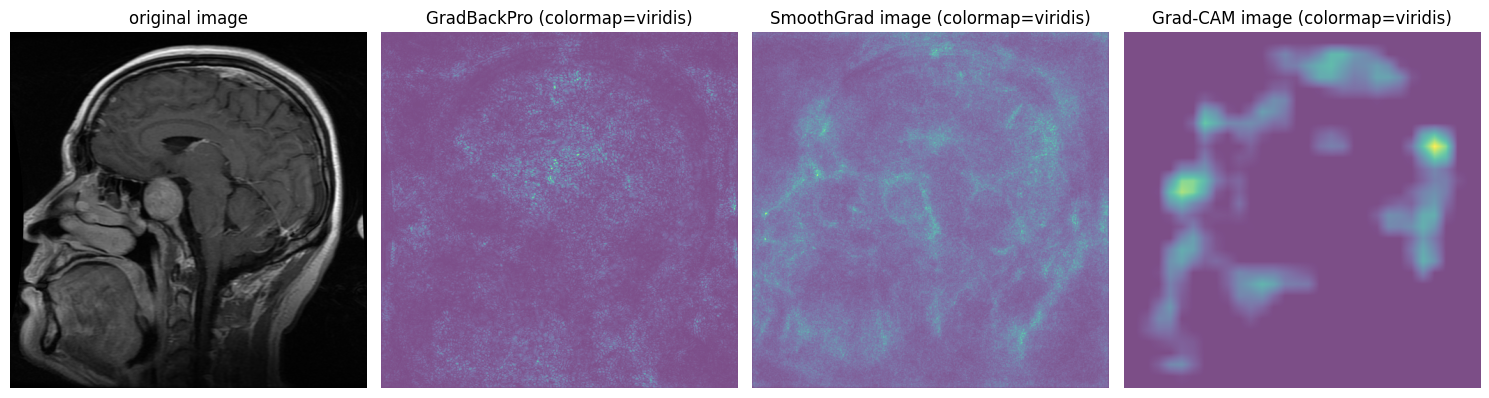

In [ ]:
import random

####################################
## prepare the 3 different types of saliency maps

sample_idx = random.randint(0, len(y_train))

label = y_train.iloc[sample_idx]
img   = x_train[sample_idx]
target_class_idx = label          ## label is the label of one sample image we withdrew from the test set

saliency = Saliency(tumor_model, model_modifier=model_modifier, clone=True)
gradcam  = Gradcam(tumor_model,  model_modifier=model_modifier, clone=True)

saliency_map = generate_saliency_map(tumor_model, img, target_class_idx, smooth_samples=0)   # 0: no smoothing
smooth_saliency_map = generate_saliency_map(tumor_model, img, target_class_idx, smooth_samples=40)
gradcam_results     = generate_gradcam(tumor_model, img, target_class_idx)

####################################
## plot 4 images in a row

## pick different colormap
#cmap = 'jet'
cmap = 'viridis'

fig, axs = plt.subplots(1,4, figsize=(15,4))
## original image
axs[0].imshow(np.mean(img, axis=-1, keepdims=True), cmap='gray')
axs[0].set_title(f'original image')
## Just Saliency image
axs[1].imshow(saliency_map[0], alpha=0.7, cmap=cmap)
axs[1].set_title(f'GradBackPro (colormap={cmap})')
## SmoothGrad image
axs[2].imshow(smooth_saliency_map[0], alpha=0.7, cmap=cmap)
axs[2].set_title(f'SmoothGrad image (colormap={cmap})')
# ## Grad-CAM
axs[3].imshow(gradcam_results[0], alpha=0.7, cmap=cmap)
axs[3].set_title(f'Grad-CAM image (colormap={cmap})')
## others
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
plt.tight_layout()
plt.show();

We observed that regions that triggered the tumor classifications are not the tumor itself, but some other unrelated regions in the brain. It is unknown to us why, but this definitely is observable on many occasions. Although it is preliminary to make any claim, saliency maps definitely help us discover some interesting clues, perhaps leading to new cancer diagnostics.

### VGG Confusion Matrix

Confusion Matrix:
[[125  33   0]
 [  4 261   0]
 [  3   1 183]]


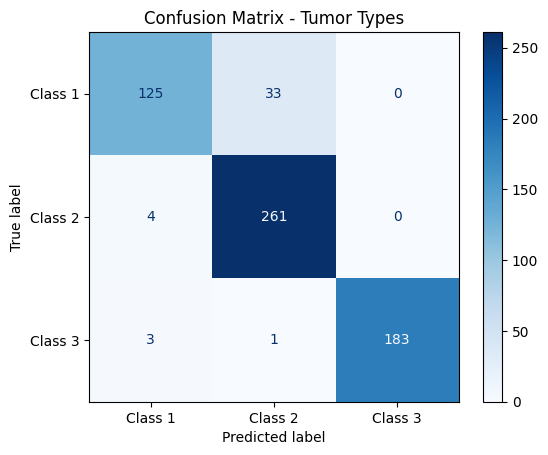

In [ ]:

# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred_int)
# Printing confusion matrix
print("Confusion Matrix:")
print(cm)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_int)
# Defining classes labels
class_names = ['Class 1', 'Class 2', 'Class 3']
# Create confusion matrix display object
cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
# Plot confusion matrix
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Tumor Types")
plt.show()


### Confusion Matrix Explanation:
Based on the confusion matrix above, we can calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for each class of tumor:

Class 1 Tumor:

*   TP: 125 instances were correctly predicted as Class 1 Tumor.
*   FP: 4 + 3 = 7 instances were incorrectly predicted as Class 1 Tumor.
*   FN: 33 + 0 = 33 instances of Class 1 Tumor were incorrectly predicted as other classes.
*   TN: All remaining instances, specifically 261 + 1 + 0+ 183 = 445 instances, are true negatives, as they are correctly classified as not being Class 1 Tumor.

Class 2 Tumor:

*   TP: 261 instances were correctly predicted as Class 2 Tumor.
*   FP: 33 + 1 = 34 instances were incorrectly predicted as Class 2 Tumor.
*   FN: 4 + 0 = 4 instances of Class 2 Tumor were incorrectly predicted as other classes.
*   TN: All remaining instances, specifically 125 + 0 + 3 + 183 = 311 instances, are true negatives, as they are correctly classified as not being Class 2 Tumor.

Class 3 Tumor:

*   TP: 183 instances were correctly predicted as Class 3 Tumor.
*   FP: 0 + 0 = 0 instances were incorrectly predicted as Class 3 Tumor.
*   FN: 3 + 1 = 4 instances of Class 3 Tumor were incorrectly predicted as other classes.
*   TN: All remaining instances, specifically 125 + 33 + 4 + 261 = 423 instances, are true negatives, as they are correctly classified as not being Class 3 Tumor.

These statistics provide the foundation for our further classification report, which will be demonstrated in the later part.


### VGG Classification Report

In [ ]:
# Printing classification report
print("Classification report Test Dataset: \n")
print(classification_report(y_test, y_pred_int))

Classification report Test Dataset: 

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       158
           1       0.88      0.98      0.93       265
           2       1.00      0.98      0.99       187

    accuracy                           0.93       610
   macro avg       0.94      0.92      0.93       610
weighted avg       0.94      0.93      0.93       610



### Classification Report Explanation:
Based on this classification report, we can interpret and analyze each metric based on our derivation of True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) statistics before.

Class 1 Tumor Performance Analysis:

* Precision: 0.95, which means that out of all instances predicted as Class 1 Tumor, 95% were correctly classified (TP). The remaining 5% were actually other classes (FP).
* Recall: 0.79, which means that out of all actual Class 1 Tumor instances, 79% were correctly predicted (TP). The remaining 21% were misclassified as other classes (FN).
* F1-score: 0.86, which is the harmonic mean of precision and recall. This score provides a balanced measure of the model's classification performance for Class 1 Tumor, considering both precision and recall metrics before.

Class 2 Tumor Analysis:

* Precision: 0.88, which means that out of all instances predicted as Class 2 Tumor, 88% were correctly classified (TP). The remaining 12% were actually other classes (FP).
* Recall: 0.98, which means that out of all actual Class 2 Tumor instances, 98% were correctly predicted (TP). The remaining 2% were misclassified as other classes (FN).
* F1-score: 0.93, which is the harmonic mean of precision and recall. This score provides a balanced measure of the model's classification performance for Class 2 Tumor, considering both precision and recall metrics before.

Class 3 Tumor Analysis:

* Precision: 1.00, which means that out of all instances predicted as Class 3 Tumor, 100% were correctly classified (TP).
* Recall: 0.98, which means that out of all actual Class 3 Tumor instances, 98% were correctly predicted (TP). The remaining 2% were misclassified as other classes (FN).
* F1-score: 0.99, which is the harmonic mean of precision and recall. This score provides a balanced measure of the model's classification performance for Class 3 Tumor, considering both precision and recall metrics before.

Overall Classification Performance Analysis:

* Accuracy: 0.93, which means that 93% of all instances in the test dataset were correctly classified.

* Macro avg F1-score: 0.93, which indicates the model's performance is relatively balanced across the classes.

* Weighted avg F1-score: 0.93, which provides an overall measure of the model's performance, taking class sizes into account.

In summary, the classification report indicates that the model performs best in classifying Class 2 Tumor and Class 3 Tumor, with relatively high precision, recall, and F1-scores. However, the model struggles more with Class 1 Tumor, as evidenced by lower precision and recall values. Based on this analysis, we should consider focusing on improving the model's classification performance in Class 1 Tumor while maintaining its effectiveness in Class 2 and Class 3 Tumor.


## 13. Future Work and Scope of Improvement
For our **custom-built CNN model as baseline model**, we'll continue to apply various techniques in Data Augmentation besides the elastic deformation technique we applied.
1.  We might consider affine transformation, which is a type of geometric transformation that applies a combination of translation, rotation, scaling, and shearing to an image to generate new training data. An affine transformation can be represented as a matrix, which is used to transform the coordinates of each pixel in the image. We believe this type of relatively reservative transformation can help our model generalize more to the unseen data while preserving the biological features of our tumor image.

2.  There are still multiple directions for features we can transform in terms of the images, like rotation angle, brightness, flipping, etc. We might consider a grid search for hyper-parameters in the data augmentation approach to see which combination of hyper-parameters provides the best performance.

3. Applying noisy labels helps a model learn the true features by forcing it to become more robust and less reliant on individual labels. By including noisy labels in the training data, the model is exposed to variations in the labels and learns to focus on the features that are more robust to the label noise.
Adding noisy labels can also help the model to learn more generalizable features that are common across multiple labels (for example, we can flip label for 40% of the dataset with noise rate of 0.4).


For our **transferred learning models**, there are 2 main directions:
1.   Leveraging on the shoulders of giants:
    *   We can use different pre-trained weights as our initial weights. ImageNet (our current choice of weights) is trained for 1000 objects, with plenty of images of animals. These are good, but not ideal, because they are not medical images.
    *   We later found BraTS (Brain Tumor Segmentation), a medical image dataset released from University of Pennsylvania,
    *   There are archtectures specifially crafted for medical scanned images, such as U-Net or V-net, and are pretrained for BraTS images.
    *   We can leverage on these architectures and pre-trained weights, before targeting our own tumor images for domain specific model training.
2.   Continous improvement on current VGG/Resnet models:
    *   Although we managed to train the model with all images, we face out-of-memory issues during the training. Optimizing the data pipeline to utilize all images as tensors with pre-fetched datasets will provide a more smooth training procedure on the potency of VGG & Resnet as tumor classifying architectures.
    *   We may further fine-tune the VGG & Resnet architectures by enabling the weights of the layers near the output as trainable.

Both directions regarding transferred learning are worth trying, and are expected to bring improvement in classification of tumors.







## 14. Conclusion & Recommendations
Based on the results of our **custom-built CNN model as baseline model**, it is a reliable and efficient method for predicting brain tumor types. With a test  accuracy of 88%, the model has demonstrated a strong ability to correctly classify the three tumor types evaluated. However, it is important to note that the performance can still be improved with more advanced techniques like transfer learning.

Based on the results of our **transfer learning model**,  our **final VGG model** appears to perform the best. It is able to classified the 3 types of brain tumor with train accuracy of 98% and test accuracy of 93%. The ResNet performs worse than our baseline model probably for the following reasons:

*   ResNet is more complex in architecture, prone to overfitting if data not
properly regularized
*   ResNet may require a larger amount of training data to perform as well as VGG due to its complexity. That is, the performance of a neural network heavily relies on the quality and quantity of training data.

Based on **saliency maps** from **final VGG model**, we observed that regions that triggered the tumor classifications are not the tumor itself, but some other unrelated regions in the brain. It is unknown to us why, but this definitely is observable on many occasions. Although it is preliminary to make any claim, saliency maps definitely help us discover some interesting clues, perhaps leading to new cancer diagnostics.

Furthermore, it is critical to consider the impact of **false negatives** and **false positives** when using any type of cancer diagnostic model. False negatives can result in missed or delayed treatment, which can have serious consequences for patients. Therefore, it is recommended that any predictions made by the model are thoroughly double-checked and verified to ensure the most accurate diagnosis possible. On the other hand, false positives can lead to unnecessary or invasive treatments, so the balance between sensitivity and specificity of the model should be carefully considered.

Overall, our **final VGG model** provides a promising approach for predicting brain tumor types, but it should be used in conjunction with other diagnostic tools and expert medical opinions for the best patient outcomes.

## 15. References

Best Practices for Convolutional Neural Networks Applied to Visual, https://www.microsoft.com/en-us/research/wp-content/uploads/2003/08/icdar03.pdf.

Cheng, Jun, et al. “Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation and Partition.” PLOS ONE, vol. 10, no. 10, 2015, https://doi.org/10.1371/journal.pone.0140381.

Cheng, Jun, et al. “Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector Representation.” PLOS ONE, vol. 11, no. 6, 2016, https://doi.org/10.1371/journal.pone.0157112.

George Bebis, et al. "Learning affine transformations", Pattern Recognition,
Volume 32, Issue 10, 1999, Pages 1783-1799, ISSN 0031-3203,
https://doi.org/10.1016/S0031-3203(98)00178-2.

YILMAZ, Volkan. “Elastic Deformation on Images.” Medium, Towards Data Science, 28 June 2019, https://towardsdatascience.com/elastic-deformation-on-images-b00c21327372.




## 16. Appendix

### Elastic Transformation Picture

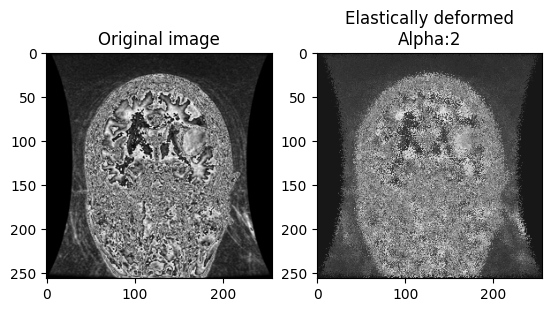

In [ ]:
np.random.seed(1234)
#Data augmentation exploration

# Loading the brain image
img = X_train[3][:,:,0]

# Defining the elastic deformation parameters
alpha = 2

# Generating the displacement grid
displacement = np.random.randn(2, img.shape[0], img.shape[1]) * alpha

# Applying the elastic deformation
deformed_img_data = elasticdeform.deform_grid(img, displacement)

# Adding the channel dimension back
deformed_img = np.expand_dims(deformed_img_data, axis=-1)

# Define the data generator with elastic deformation
datagen = ImageDataGenerator(
    preprocessing_function=lambda x: np.squeeze(elasticdeform.deform_grid(x, displacement)))

# Plot the original and deformed images side by side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(deformed_img, cmap='gray')
axs[1].set_title(f'Elastically deformed\nAlpha:{alpha}')

plt.show()

### Min-Max Explanation

In [ ]:
data_full['Label'].loc[[3,4,5]]

3    1
4    1
5    1
Name: Label, dtype: int64

In [ ]:
data_full['Label'].loc[[800,801,802]]

800    2
801    2
802    2
Name: Label, dtype: int64

In [ ]:
data_full['Label'].loc[[1000,1001,1002]]

1000    3
1001    3
1002    3
Name: Label, dtype: int64

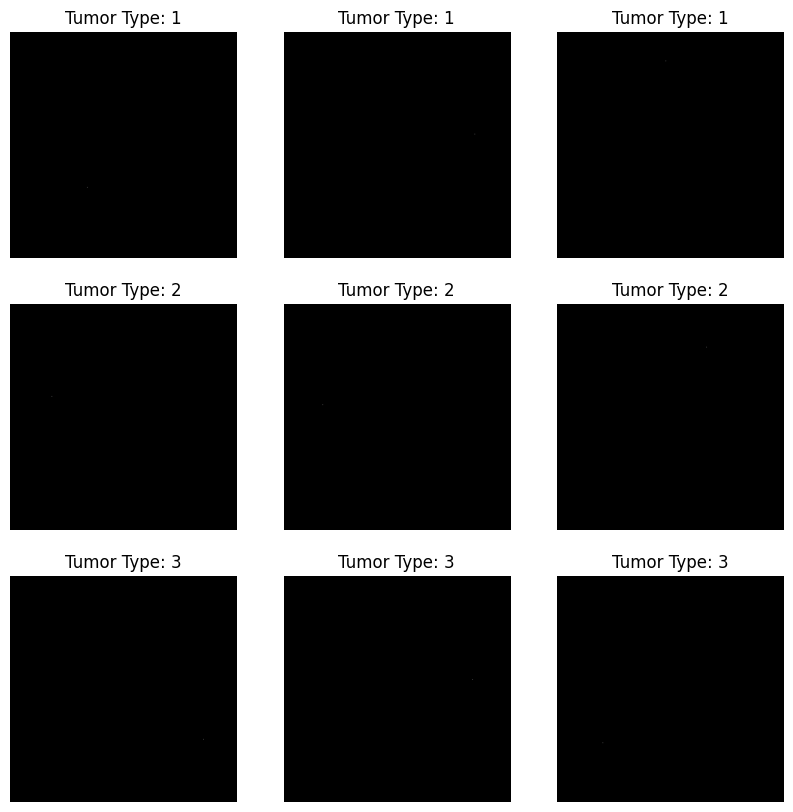

In [ ]:
Image_prep = np.reshape(np.vstack(data_full.Image.loc[[3,4,5,800,801,802,1000,1001,1002]].to_list()), (-1, 512, 512, 1))
image_list = data_full['Image'].loc[[3,4,5,800,801,802,1000,1001,1002]].tolist()
label_list = data_full['Label'].loc[[3,4,5,800,801,802,1000,1001,1002]].tolist()
for i in range(len(Image_prep)):
    min_val = np.min(Image_prep[i])
    max_val = np.max(Image_prep[i])
    Image_prep[i] = (Image_prep[i] - min_val) / (max_val - min_val)

# Save normalized images
for i in range(len(Image_prep)):
    normalized_image = (Image_prep[i] * 255).astype(np.uint8)
    Image_prep[i] = normalized_image

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(9):
    row = i // 3
    col = i % 3
    ax[row][col].imshow(Image_prep[i], cmap='gray')
    ax[row][col].axis('off')
    ax[row][col].set_title('Tumor Type: {}'.format(label_list[i]))
plt.show()

As we can see from plots above, min-max normalization is not producing the desirable expectations due to clipping, which occurs when pixel values in an image are normalized to fall within a certain range, typically between 0 and 1. If the range is too narrow, some pixel values may be outside the range and get clipped to 0, resulting in a completely black image.

